# References and Resources 

* https://valueml.com/steel-surface-inspection-in-keras-python/
* [NN for steel surface defect detection](https://www.researchgate.net/publication/271133065_Convolutional_Neural_Networks_for_Steel_Surface_Defect_Detection_from_Photometric_Stereo_Images)
* https://www.sciencedirect.com/science/article/pii/S2405896318321001
* https://www.researchgate.net/publication/344279811_Surface_defect_detection_of_steel_strips_based_on_classification_priority_YOLOv3-dense_network
* [Augmentation for Object detection](https://arxiv.org/pdf/1906.11172.pdf)
* https://blog.paperspace.com/data-augmentation-for-object-detection-rotation-and-shearing/
* http://sefidian.com/2020/01/13/rcnn-fast-rcnn-and-faster-rcnn-for-object-detection-explained/#:~:text=Below%20is%20a%20succinct%20summary%20of%20the%20steps,boxes%20for%20each%20identified%20object%20in%20the%20image.

# Imports

In [1]:
import sys 
import os
import pandas as pd
import numpy as np
from glob import glob
import gc
from lxml import etree



from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score
from mlxtend.plotting import plot_confusion_matrix

from tqdm import tqdm

#plotting
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
import seaborn as sns
from termcolor import colored

import cv2
import tensorflow as tf 
import tensorflow.keras.backend as K
import tensorflow_addons as tfa



pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)



def  color_print(print_str,
                 print_color='green'):
    
    '''print in given  color (default green)'''
    print(colored(print_str,print_color))

# Config

In [2]:
class CFG:
    seed = 7
    img_size = (256,512,3)
    BATCH_SIZE = 32
    validation_size = 0.2
    BUFFER_SIZE = 100

def set_seed(seed=7):
    '''set seed for reproduciblity'''

    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    print(f'Setting Random Seed  to {seed}')

Autotune = tf.data.AUTOTUNE
set_seed()

Setting Random Seed  to 7


# Loading Data


**Get paths for all the images and labels**

In [3]:
image_dir = '../input/defects-class-and-location/images/images/'
label_dir = '../input/defects-class-and-location/label/label/'


In [4]:
#selecting the xml files for getting the labels and features 
label_paths = glob(f'{label_dir}*.xml')

len(label_paths)

2280

In [5]:

#selecting the image file paths 
image_paths = glob(f'{image_dir}/*/*.jpg')
len(image_paths)

2306

In [6]:
#checking if the image and label names match 


img_names = [path.rsplit('/',1)[1].split('.')[0] for path in image_paths] 

sum([lab_path.rsplit('/',1)[1].split('.')[0] in img_names for lab_path in label_paths])

2280

In [7]:
def read_xml(path):
    '''read the xml label file to get the bounding box'''
    #dictionary to store the details 
    d = {}
    
    d['file_id'] = path.rsplit('/',1)[1].split('.')[0]
    
    with open(path) as f:
        
        xml_f = etree.HTML(f.read())
        
    # width
    d["width"] = int(xml_f.xpath("//size/width/text()")[0])
    # height
    d['height'] = int(xml_f.xpath("//size/height/text()")[0])  
    # bounding box coordinates
    d["xmin"] = int(xml_f.xpath("//bndbox/xmin/text()")[0]) / d["width"]
    d['xmax'] = int(xml_f.xpath("//bndbox/xmax/text()")[0]) / d["width"]
    d['ymin'] = int(xml_f.xpath("//bndbox/ymin/text()")[0]) / d['height']
    d['ymax'] = int(xml_f.xpath("//bndbox/ymax/text()")[0]) / d['height']
    
    return d


**Getting image labels and metadata**

In [8]:
img_metadata = []

for label in tqdm(label_paths):
    
    #read label xml 
    imageinfo = read_xml(label)
    
    # get image path
    file_id = imageinfo['file_id']
    imageinfo['image_path'] = glob(f'{image_dir}*/{file_id}.jpg')[0]
    
    # defect class
    imageinfo['defect_class'] = imageinfo['image_path'].rsplit('/',2)[1]
    
    img_metadata.append(imageinfo)
    
    
df = pd.DataFrame.from_records(img_metadata)

100%|██████████| 2280/2280 [00:30<00:00, 74.39it/s]


**Encoding the classes to integers**

In [9]:
#storing class to idx dictionary in config
CFG.class_dict = {val:idx for idx,val in enumerate(df.defect_class.unique())}
CFG.num_classes = len(CFG.class_dict)

#inverse mapping dictionary 
int_2_class = {idx:clss for clss,idx in CFG.class_dict.items()}


CFG.class_dict

{'water_spot': 0,
 'punching_hole': 1,
 'silk_spot': 2,
 'oil_spot': 3,
 'crescent_gap': 4,
 'welding_line': 5,
 'waist folding': 6,
 'inclusion': 7,
 'crease': 8,
 'rolled_pit': 9}

**Mapping labels to thier integer ids**

In [10]:
df['defect_id'] = df['defect_class'].map(CFG.class_dict)

**Checking the distribution of image height and widths**

In [11]:
df['width'].unique(),df['height'].unique()

(array([2048]), array([1000]))

**Checking the class labels**

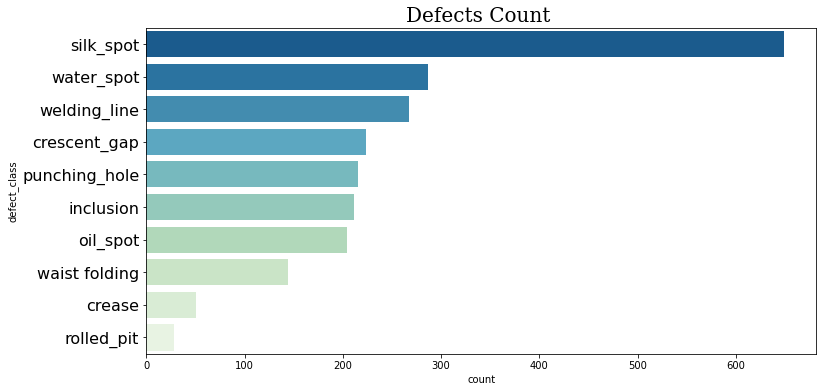

In [12]:
plt.figure(figsize=(12,6))
plt.yticks(fontsize=16)
sns.countplot(y="defect_class",
              data=df,
              palette="GnBu_r",
              order=df['defect_class'].value_counts().index,
              linewidth=3)
plt.title("Defects Count ",font="Serif", size=20,color='k')
plt.show()

In [13]:
df.head()

,file_id,width,height,xmin,xmax,ymin,ymax,image_path,defect_class,defect_id
0,img_01_425241700_00384,2048,1000,0.453125,0.644043,0.657,1.000,../input/defects-class-and-location/images/ima...,water_spot,0
1,img_06_425505000_00050,2048,1000,0.907227,0.960449,0.406,0.466,../input/defects-class-and-location/images/ima...,punching_hole,1
2,img_06_3436814300_00056,2048,1000,0.021484,0.228027,0.011,0.280,../input/defects-class-and-location/images/ima...,silk_spot,2
3,img_07_425390900_00077,2048,1000,0.756348,0.801270,0.196,0.275,../input/defects-class-and-location/images/ima...,oil_spot,3
4,img_01_425005700_00501,2048,1000,0.415527,0.611328,0.042,1.000,../input/defects-class-and-location/images/ima...,silk_spot,2


In [14]:
'''

def upsample(df):
    """balance the labels, by uplsampling minority labels"""
    new_df_list = []
    
    max_count = df['defect_class'].value_counts().max()
    for clss in df['defect_class'].unique():
        clss = df[df['defect_class']==clss].reset_index(drop=True)
        
        clss_ratio = int(max_count / len(clss))
        
        clss_list = [clss for _ in range(clss_ratio)]
        
        new_df_list.extend(clss_list)
        
        
    new_df = pd.concat(new_df_list,axis=0,ignore_index=True)
    
    
    return new_df
        

df = upsample(df)

plt.figure(figsize=(12,6))
plt.yticks(fontsize=16)
sns.countplot(y="defect_class",
              data=df,
              palette="GnBu_r",
              order=df['defect_class'].value_counts().index,
              linewidth=3)
plt.title("Defects Count (upsampling) ",font="Serif", size=20,color='k')
plt.show()

'''

'\n\ndef upsample(df):\n    """balance the labels, by uplsampling minority labels"""\n    new_df_list = []\n    \n    max_count = df[\'defect_class\'].value_counts().max()\n    for clss in df[\'defect_class\'].unique():\n        clss = df[df[\'defect_class\']==clss].reset_index(drop=True)\n        \n        clss_ratio = int(max_count / len(clss))\n        \n        clss_list = [clss for _ in range(clss_ratio)]\n        \n        new_df_list.extend(clss_list)\n        \n        \n    new_df = pd.concat(new_df_list,axis=0,ignore_index=True)\n    \n    \n    return new_df\n        \n\ndf = upsample(df)\n\nplt.figure(figsize=(12,6))\nplt.yticks(fontsize=16)\nsns.countplot(y="defect_class",\n              data=df,\n              palette="GnBu_r",\n              order=df[\'defect_class\'].value_counts().index,\n              linewidth=3)\nplt.title("Defects Count (upsampling) ",font="Serif", size=20,color=\'k\')\nplt.show()\n\n'

**Plotting some sample images**

In [15]:
def load_image(image_file):
    '''load a image file'''
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image,channels = CFG.img_size[2])
    image = tf.cast(image, tf.float32)
    image = image/255.0         
    
    return image


def resize(input_image):
    '''resize the image based on given height and width'''
    input_image = tf.image.resize(input_image, CFG.img_size[:2])
    
    return input_image

def load_resize_image(image_path):
    '''load and resize the image'''
    img = load_image(image_path)
    img = resize(img)
    img = tf.cast(img, tf.float32)
    return img

In [16]:
def plot_sample(sample_id):
    
    '''plot a sample image'''
    
    xmin,xmax,ymin,ymax,label = df.loc[sample_id,['xmin','xmax','ymin','ymax','defect_class']]

    xmin = xmin * 2048
    xmax = xmax * 2048
    ymin = ymin * 1000
    ymax = ymax * 1000


    fig,ax = plt.subplots(figsize = (10,5))
    rect = Rectangle(xy = (xmin,ymin),
                     width = (xmax - xmin),
                     height = (ymax - ymin), 
                     fill = False, 
                     color = "r")  

    ax.axes.add_patch(rect)

    plt.imshow(plt.imread(df.loc[sample_id,'image_path']),cmap = 'gray')
    plt.title(f'Defect - {label}')
    plt.show()
    

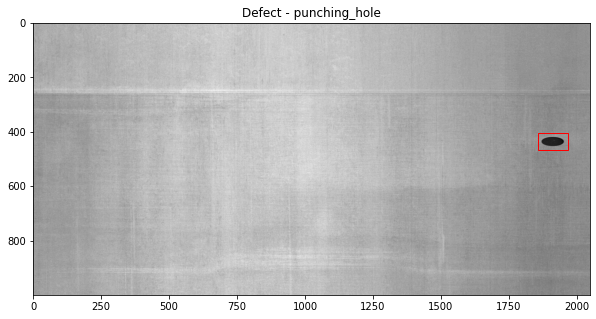

In [17]:
plot_sample(1)

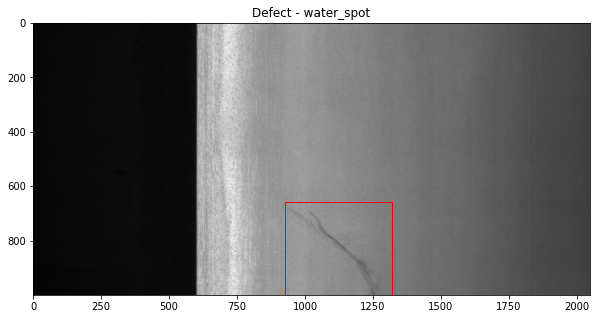

In [18]:
plot_sample(0)

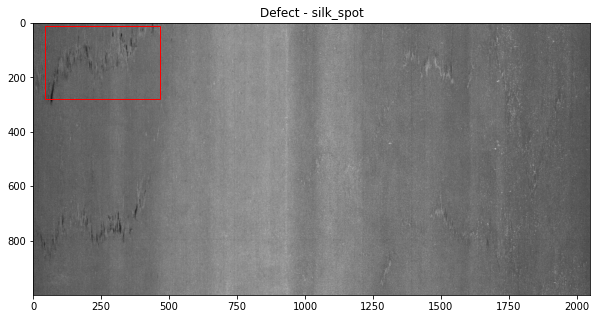

In [19]:
plot_sample(2)

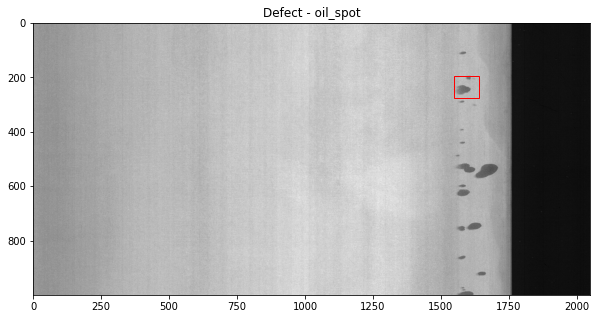

In [20]:
plot_sample(3)

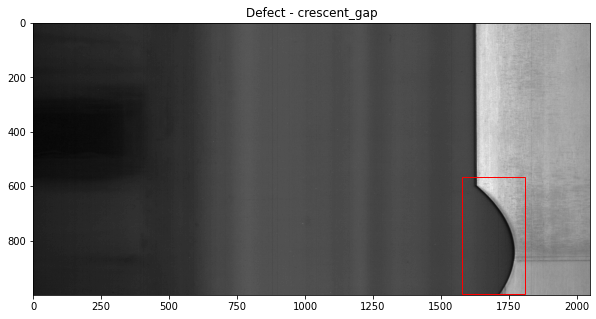

In [21]:
plot_sample(200)

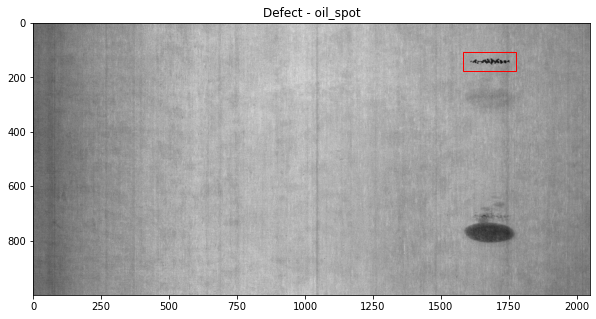

In [22]:
plot_sample(400)

# Data Pipeline

**Loading images**

**Data Augmentation**

In [23]:
def augment_image(image):
    '''perform simple image augmentations'''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_crop(image, size=CFG.img_size)
    
#     rot = tf.random.normal((1,),mean = 0.35, stddev=0.15)
    
#     if rot > 0.5:
#         image = tf.image.rot90(image)

    return image 

**TF data Pipeline**

In [24]:
def get_dataset(df,
                labels_exist = True,
                shuffle = True):
    

    if labels_exist:
        im_ds = tf.data.Dataset.from_tensor_slices(df.image_path)
        im_ds = im_ds.map(load_resize_image)
        
        
        xmin = tf.data.Dataset.from_tensor_slices(df['xmin'].values)
        ymin = tf.data.Dataset.from_tensor_slices(df['ymin'].values)
        xmax = tf.data.Dataset.from_tensor_slices(df['xmax'].values)
        ymax = tf.data.Dataset.from_tensor_slices(df['ymax'].values)
        labels = tf.data.Dataset.from_tensor_slices(df['defect_id'].values)

        
        
        labels_ds = tf.data.Dataset.zip((labels,xmin,xmax,ymin,ymax)
                                        )         
        
        dataset = tf.data.Dataset.zip((im_ds,labels_ds))
        
        
        
    else:
        dataset = tf.data.Dataset.list_files(df.image_path)

        dataset = dataset.map(load_resize_image,
                              num_parallel_calls=Autotune)
     
    if shuffle:
        
        dataset = dataset.shuffle(CFG.BUFFER_SIZE)
        
    dataset = dataset.batch(CFG.BATCH_SIZE,drop_remainder=True)
    return dataset

**Splitting the dataset into training and validation**

In [25]:
train_df,val_df = train_test_split(df,test_size = 0.2,stratify = df['defect_id'])

In [26]:
#get the training dataset
train_dataset= get_dataset(df = train_df)
val_dataset= get_dataset(df = val_df)


2022-10-12 13:58:22.320164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 13:58:22.413169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 13:58:22.414060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 13:58:22.416646: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-10-12 13:58:25.231781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


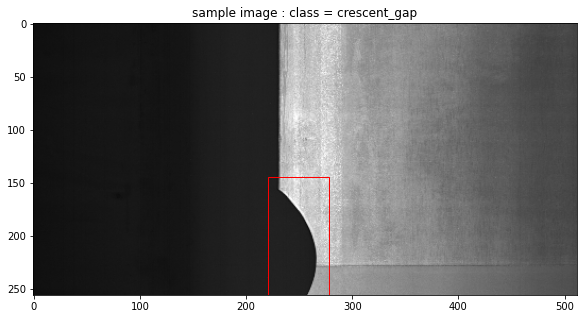

In [27]:
# sanity check 
for im,label in train_dataset.take(1):
    
#     defect_type = label[0]
    defect_type,xmin,xmax,ymin,ymax = label
    
#     taking the first elem

    xmin = xmin[0].numpy()* CFG.img_size[1]
    xmax = xmax[0].numpy() * CFG.img_size[1]
    ymin = ymin[0].numpy() * CFG.img_size[0]
    ymax = ymax[0].numpy() * CFG.img_size[0]
    
#     print(xmin,xmax,ymin,ymax)
    fig,ax = plt.subplots(figsize = (10,5))

    rect = Rectangle((xmin,ymin),
                     (xmax - xmin),
                     (ymax - ymin), 
                     fill = False, 
                     color = "r")  
    
    ax.axes.add_patch(rect)
    
    
    plt.title(f'sample image : class = {int_2_class[defect_type[0].numpy()]}')
    
    
    plt.imshow(im[0],
               cmap='gray')

**Distribution of classes**

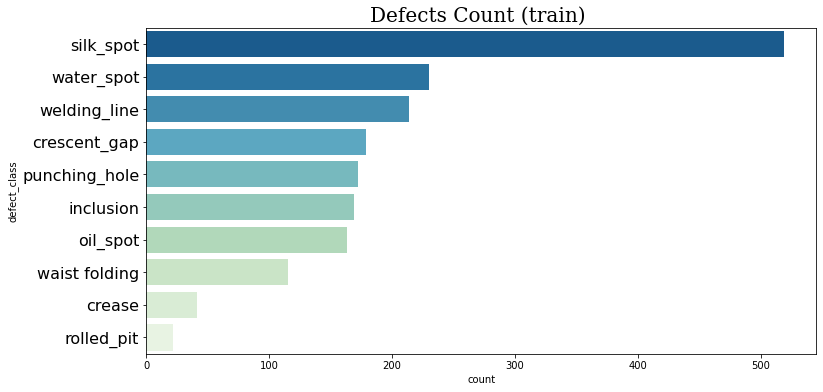

In [28]:
plt.figure(figsize=(12,6))
plt.yticks(fontsize=16)
sns.countplot(y="defect_class",
              data=train_df,
              palette="GnBu_r",
              order=train_df['defect_class'].value_counts().index,
              linewidth=3)
plt.title("Defects Count (train) ",font="Serif", size=20,color='k')
plt.show()

# Training 

**Custom-CNN**

In [29]:

def conv_block(input_layer,
               filters,
               name,
               size=3, 
               strides=2, 
               activation=tf.keras.layers.ReLU, 
               ):
    
    '''perform a downsampling by applying a convolution,followed by batch norm and activation'''
    conv = tf.keras.layers.Conv2D(filters, 
                                  size, 
                                  strides=strides, 
                                  padding='valid', 
                                  use_bias=False, 
                                  name=f'conv_block_{name}')(input_layer)

    
    conv = tf.keras.layers.BatchNormalization()(conv)
        
    conv = activation()(conv)
    
    conv = tf.keras.layers.MaxPooling2D()(conv)

    return conv


def dense_block(input_layer,
               units,
               name, 
               activation=tf.keras.layers.ReLU, 
               ):
    
    '''dense layer followed by dropout,batch norm, and activation'''
    x = tf.keras.layers.Dense(units=units , 
                              name=f'dense_block_{name}')(input_layer)

    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
        
    x = activation()(x)

    return x


In [30]:
class model_config:
    
    conv_units = [32,64,128,256]
    filter_size= [(5,5),(3,3),(3,3),(3,3)]
    strides = [2,1,1,1]
    
    dense_units = [512,256]
    
    
    

In [31]:
def build_model(model_config):
    
    # --------------Conv layers 
    inp = tf.keras.layers.Input(shape = CFG.img_size)
    x = conv_block(input_layer = inp,
                   filters = model_config.conv_units[0],
                   name = 0,
                   size=model_config.filter_size[0], 
                   strides=2, 
                   )

    
    for num,conv_layer in enumerate(model_config.conv_units[1:],start = 1):
        
        x = conv_block(x,
                       model_config.conv_units[num],
                       num,
                       model_config.filter_size[num],
                       model_config.strides[num])
        
    # ---------------dense blocks 
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    
     #bounding box detector
    x1 = dense_block(input_layer= x,units = model_config.dense_units[1], name = 1)
    x1 = dense_block(input_layer= x,units = model_config.dense_units[1], name = 1)

    
    xmin = tf.keras.layers.Dense(units = 1 ,name = 'xmin')(x1)

    xmax = tf.keras.layers.Dense(units = 1,name = 'xmax')(x1)
    ymin = tf.keras.layers.Dense(units = 1,name = 'ymin')(x1)
    ymax = tf.keras.layers.Dense(units = 1,name = 'ymax')(x1)

    
     #defect type detector
        
    x2 = dense_block(input_layer= x,units = model_config.dense_units[0], name = 1)
    x2 = dense_block(input_layer= x,units = model_config.dense_units[1], name = 2)

    class_out = tf.keras.layers.Dense(units = CFG.num_classes ,name = 'class_out',activation='softmax')(x2)
    
    
    return tf.keras.Model(inputs = inp,
                          outputs = [class_out,xmin,xmax,ymin,ymax])

    
        
    
baseline_model = build_model(model_config)

In [32]:
def plot_history(history,addn_metric=None):
    '''
    Inputs
    history:history object from tensorflow
    add_metric: metric name in the history (like f1_score)'''
    his=pd.DataFrame(history.history)
    
    if addn_metric:
        plt.subplots(1,3,figsize=(20,6))
        
        #loss:
        ax1=plt.subplot(1,3,1)
        ax1.plot(range(len(his)),his['loss'],color='g',label='training')
        ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
        ax1.set_xlabel('EPOCHS')
        ax1.set_ylabel('LOSS')
        ax1.legend()
        ax1.set_title('Loss Per Epoch')

        #accuracy
        ax2=plt.subplot(1,3,2)
        ax2.plot(range(len(his)),his['accuracy'],color='g',label='training_acc')
        ax2.plot(range(len(his)),his['val_accuracy'],color='r',label='validation_acc')
        ax2.set_xlabel('EPOCHS')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy Per Epoch')

    
        
        ax3= plt.subplot(1,3,3)
        ax3.plot(range(len(his)),his[f'{addn_metric}'],color='g',label='training')
        ax3.plot(range(len(his)),his[f'val_{addn_metric}'],color='r',label='validation')
        ax3.set_xlabel('EPOCHS')
        ax3.set_ylabel(f'{addn_metric}')
        ax3.legend()
        ax3.set_title(f'{addn_metric} Per Epoch')

        
    else:
        plt.subplots(1,2,figsize=(20,8))
        
    
    
        #loss:
        ax1=plt.subplot(1,2,1)
        ax1.plot(range(len(his)),his['loss'],color='g',label='training')
        ax1.plot(range(len(his)),his['val_loss'],color='r',label='validation')
        ax1.set_xlabel('EPOCHS')
        ax1.set_ylabel('LOSS')
        ax1.legend()
        ax1.set_title('Loss Per Epoch')

        #accuracy
        ax2=plt.subplot(1,2,2)
        ax2.plot(range(len(his)),his['class_out_accuracy'],color='g',label='training_acc')
        ax2.plot(range(len(his)),his['val_class_out_accuracy'],color='r',label='validation_acc')
        ax2.set_xlabel('EPOCHS')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.set_title('Accuracy Per Epoch')

        
    
    
    plt.show()  

**Additional  metrics**

In [33]:
baseline_model.compile(loss = {'class_out':'sparse_categorical_crossentropy',
                              'xmin':'mae',
                              'xmax':'mae',
                              'ymin':'mae',
                              'ymax':'mae',
                              },
                       optimizer = tf.keras.optimizers.Adam(lr = 0.001),
                       metrics = {'class_out':['accuracy']}
                      )



/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [34]:
# callbacks 
#reduce_learning rate
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(patience=2,
                                                factor=0.75,
                                                min_delta=1e-2,
                                                monitor='val_loss',
                                                verbose=1,
                                                mode='min')

#early stopping 
early_stopping=tf.keras.callbacks.EarlyStopping(patience=10,
                                             min_delta=1e-2,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              mode='min')


# exponential decay 

def lr_scheduler(epoch, 
                 lr):

    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.02)
    

    
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)



callbacks_1= [reduce_lr,early_stopping,learning_scheduler]



# Model Training

In [35]:
# number of steps per epoch
train_steps = len(train_df) // CFG.BATCH_SIZE
val_steps = len(val_df) // CFG.BATCH_SIZE

train_steps,val_steps

(57, 14)

2022-10-12 13:58:35.892135: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0004218749818392098.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00031640623637940735.


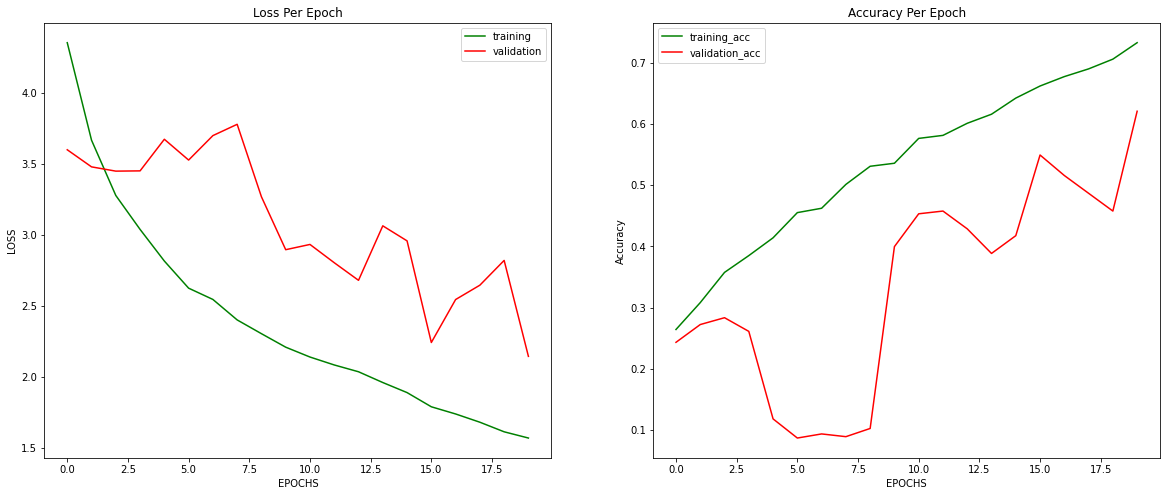

In [36]:
history = baseline_model.fit(train_dataset,
                             validation_data = val_dataset,
                             epochs = 20,
                            callbacks = callbacks_1,
                             verbose=0
                             )

plot_history(history)

In [37]:
#save model 
baseline_model.save('baselinemodel.h5')

**evaluating on the validation dataset**

In [38]:
val_ds = get_dataset(df = val_df,
                     shuffle = False)


_ = baseline_model.evaluate(val_ds)

14/14 [==============================] - 10s 697ms/step - loss: 2.1442 - class_out_loss: 1.1435 - xmin_loss: 0.2491 - xmax_loss: 0.2933 - ymin_loss: 0.1603 - ymax_loss: 0.2979 - class_out_accuracy: 0.6205


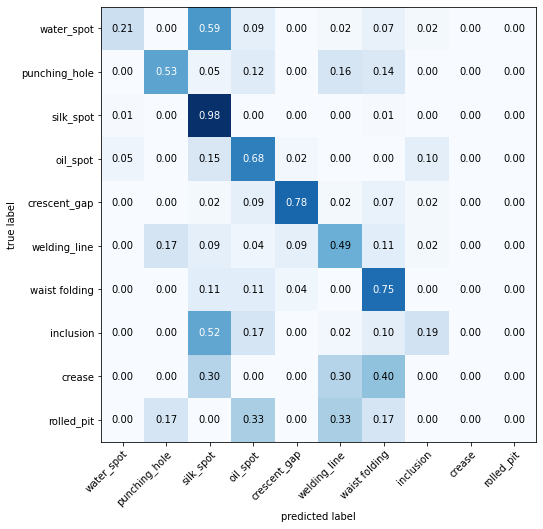

In [39]:
y_val = val_df.defect_id

val_pred,v_xmin,v_xmx,v_ymin,y_ymx = baseline_model.predict(val_ds)

#last 2 entries are dropped due to batching 
y_val = y_val[:len(val_pred)]

from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
#get confusion matrix
cm = confusion_matrix(y_val, val_pred.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=CFG.class_dict.keys(),
                                figsize=(8, 8))
fig.show()

# **Using Mobilenet base**

In [40]:
backbone = tf.keras.applications.MobileNetV2(
                                        include_top=False,
                                        input_shape = CFG.img_size,
                                        weights='imagenet',
                                        pooling = 'avg')

backbone.trainable = False

 #bounding box detector
x1 = dense_block(input_layer= backbone.output,units = 1024, name = 1)
x1 = dense_block(input_layer= x1,units = 512, name = 12)

xmin = tf.keras.layers.Dense(units = 1 ,name = 'xmin')(x1)

xmax = tf.keras.layers.Dense(units = 1,name = 'xmax')(x1)
ymin = tf.keras.layers.Dense(units = 1,name = 'ymin')(x1)
ymax = tf.keras.layers.Dense(units = 1,name = 'ymax')(x1)


 #defect type detector

x2 = dense_block(input_layer= backbone.output,units = 512, name = 21)
x2 = dense_block(input_layer= x2,units = model_config.dense_units[0], name = 22)

class_out = tf.keras.layers.Dense(units = CFG.num_classes ,name = 'class_out',activation='softmax')(x2)


backbone_model =  tf.keras.Model(inputs = backbone.input,
                      outputs = [class_out,xmin,xmax,ymin,ymax])



backbone_model.compile(loss = {'class_out':'sparse_categorical_crossentropy',
                              'xmin':'mae',
                              'xmax':'mae',
                              'ymin':'mae',
                              'ymax':'mae',},
                       optimizer = tf.keras.optimizers.Adam(lr = 0.001),
                       metrics = {'class_out':['accuracy']}
                      )


9420800/9406464 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")



Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0004218749818392098.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00031640623637940735.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.00022799983707955107.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0001642948845983483.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00011838959107990377.


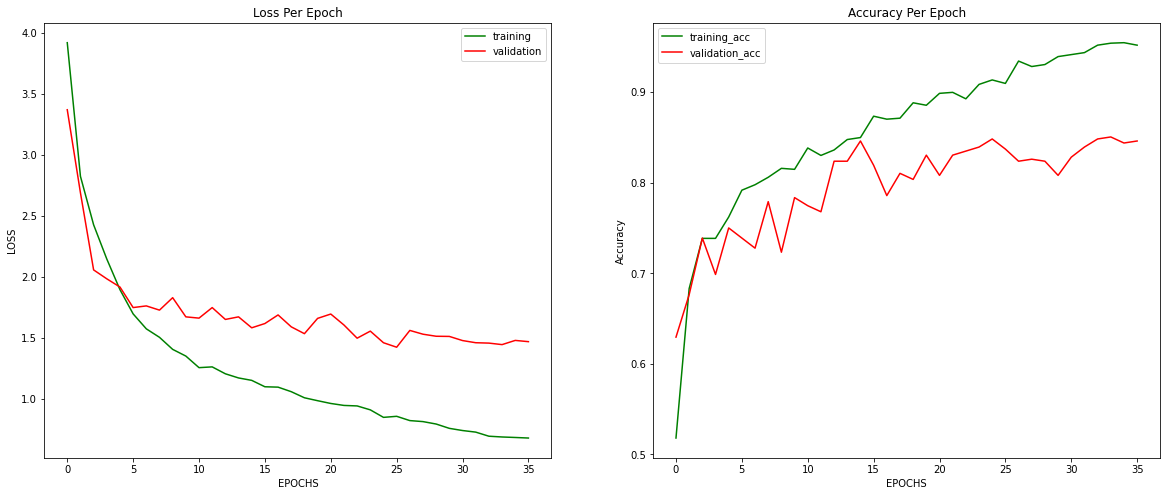

In [41]:
history2 = backbone_model.fit(train_dataset,
                     validation_data = val_dataset,
                     epochs = 40,
                    callbacks = callbacks_1,
                    verbose=0
                             )

plot_history(history2)

# **evaluate on val**

In [42]:
_ = backbone_model.evaluate(val_ds)

14/14 [==============================] - 11s 801ms/step - loss: 1.4169 - class_out_loss: 0.5181 - xmin_loss: 0.2313 - xmax_loss: 0.2618 - ymin_loss: 0.1521 - ymax_loss: 0.2536 - class_out_accuracy: 0.8371


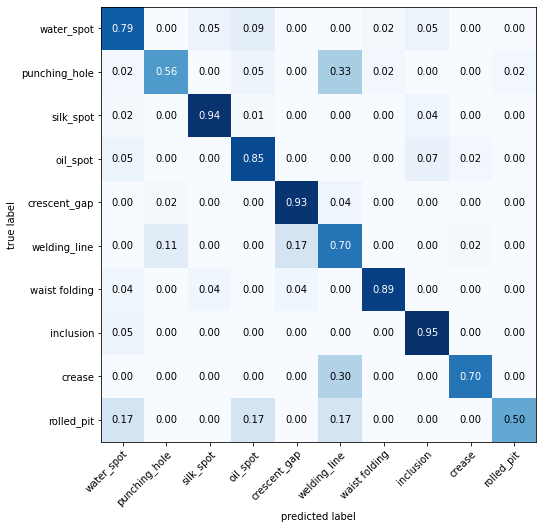

In [43]:

val_pred,v_xmin,v_xmx,v_ymin,y_ymx = backbone_model.predict(val_ds)

#last 2 entries are dropped due to batching 
y_val = y_val[:len(val_pred)]

#get confusion matrix
cm = confusion_matrix(y_val, 
                      val_pred.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=CFG.class_dict.keys(),
                                figsize=(8, 8))
fig.show()

**Unfreeze Mobilenet and train**

In [44]:
# backbone.trainable = True


# backbone_model.compile(loss = {'class_out':'sparse_categorical_crossentropy',
#                               'xmin':'mae',
#                               'xmax':'mae',
#                               'ymin':'mae',
#                               'ymax':'mae',},
#                        optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
#                        metrics = {'class_out':['accuracy']}
#                       )

# history3 = backbone_model.fit(train_dataset,
#                      validation_data = val_dataset,
#                      epochs = 5,
#                     callbacks = callbacks_1,
#                              )

In [45]:
modified_model = tf.keras.Model(inputs = backbone_model.input,
                                outputs = backbone_model.get_layer('class_out').output)

modified_model.save('mobilenet_base.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


**Model Explainibility**

In [46]:
!pip install tf_keras_vis -q
import tf_keras_vis 

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus


tf_keras_vis.__version__


'0.8.2'

In [47]:
def model_modifier_function(cloned_model):
    '''modify model activation'''
    cloned_model.layers[-1].activation = tf.keras.activations.linear

def get_saliency(img,
                 score,
                 cnn_model,
                 model_modifier=model_modifier_function):
    '''get the saliency maps for a model output'''
    
    #saliency map
    

    # Create Saliency object.
    saliency = Saliency(cnn_model,
                        model_modifier=model_modifier_function,
                        clone=True)
    #saliency map 
    sal_map  = saliency(score,
                        img,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
    return sal_map




**Evaluate**

**Perform inference**

In [48]:
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img,(512,256))
def load_image_2(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img, [256, 512])
    img = tf.cast(img,tf.float32)
    img = img/255.
    return tf.expand_dims(img,axis=0)

In [49]:
def predict(df,
            sample_id,
            model):

    
    ex = df.iloc[sample_id]
    img = load_image_2(ex['image_path'])
    img_lab = ex['defect_class']
    lab_id = ex['defect_id']
    
    
    label= model(img).numpy().squeeze()
    
    fig,ax = plt.subplots(1,2,figsize = (10,5))
    
    
    plt.subplot(1,2,1)
    plt.title(f'Pred - {int_2_class[label.argmax()]} | Original - {img_lab}')
    plt.axis('off')
    plt.imshow(img[0],
               cmap='gray')
    
    
    
    
    plt.subplot(1,2,2)
    plt.title(f'saliency (attention) map')
    sal = get_saliency(img,
                       CategoricalScore(label.argmax()),
                       cnn_model = model).squeeze(axis=0)

    plt.axis('off')
    plt.imshow(img[0])
    plt.imshow(sal,alpha=0.25,cmap='jet') #overlay   
    plt.show()



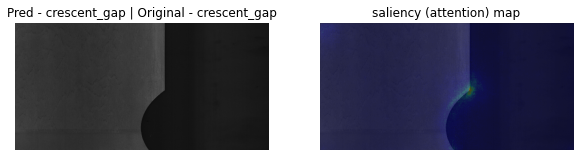

In [50]:
predict(val_df,
        26,
        modified_model)

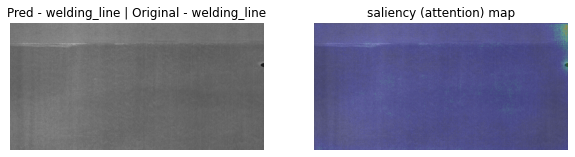

In [51]:
predict(val_df,
        100,
        modified_model)

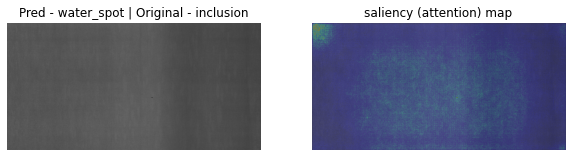

In [52]:
predict(val_df,
        1,
        modified_model)

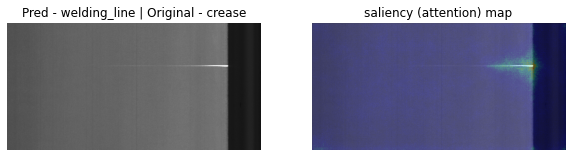

In [53]:
predict(val_df,
        12,
        modified_model)

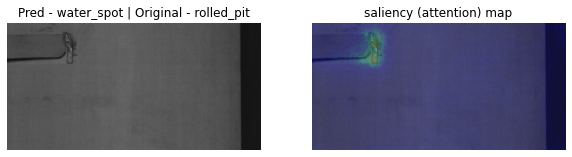

In [54]:
predict(val_df,
        300,
        modified_model)

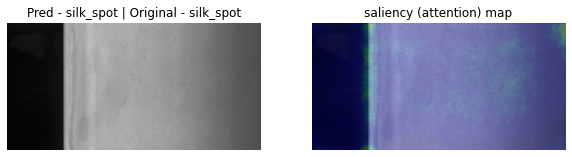

In [55]:
predict(val_df,
        50,
        modified_model)

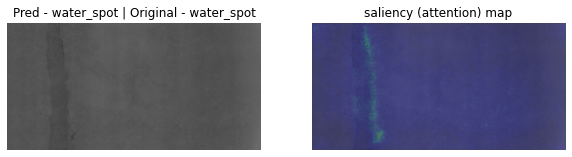

In [56]:
predict(val_df,
        30,
        modified_model)

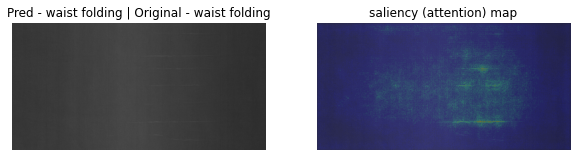

In [57]:
predict(val_df,
        65,
        modified_model)

# YOLO Model 

    work in progress

**Converting the data into YOLO annotation format**

In [58]:
def copy_file(filepath,destination):
    '''copy files from source to dest'''
    shutil.copy(src=filepath,
               dst = destination)
    
    
def get_annotations(annotations):
    '''return annotations formatted in YOLO format ,i.e [x-mid,y-mid,hieght,width], normalized by image height and width'''
    
    
    x_mid = (annotations['xmin'] + annotations['xmax']) /2
    y_mid = (annotations['ymin'] + annotations['ymax']) /2
    
    width = (annotations['xmax'] - annotations['xmin'])
    height = (annotations['ymax'] - annotations['ymin'])
    
    
    clss = row['defect_class']
    return f'{clss} {x_mid} {y_mid} {width} {height} \n'

def save_annot(path_to_save,
               annot):
    '''save annotations'''
    with open(path_to_save,'w') as f:
        f.write(annot)
        